# Projected Gradient Descent

In this tutorial we will demonstrate how to use the Projected Gradient Descent (PGD) adversarial attack.

We begine by loading a pretrained ResNet50 model:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from adversarial_attack.models import load_model
model = load_model('resnet50', device='cuda')

Next step is to load the image we want to generate an adversarial example for. To do this, we use a helper function which already applies the resizing and cropping of the original image, which is the actual shape that the ResNet50 model is expecting. The pixel values returned by the image loader will be in [0, 1].

In [3]:
from adversarial_attack.image_loaders import get_image_loader
image_loader = get_image_loader('resnet50')

Now we can load the image and display it:

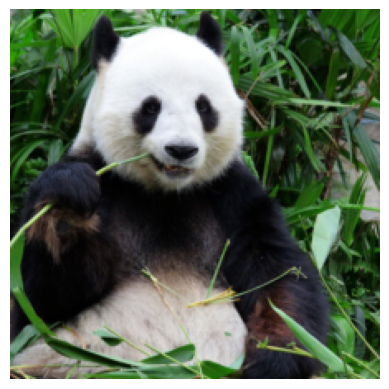

In [4]:
import matplotlib.pyplot as plt
image = image_loader('assets/panda.jpg')
plt.imshow(image.permute(1, 2, 0))  # reverse channels for matplotlib
plt.axis('off')
plt.show()

We can test that the model behaves well, by running the above image through the model. As mentioned above, our image is in [0, 1], which is not the actual range expected by ResNet50. ResNet50 preforms a normalization of the input first and the passes the image through the model. We will do the same by loading the preprocessor and the inverse preprocessor (not to worry about this yet) first:

In [5]:
from adversarial_attack.preprocessors import get_preprocessor
transform, inverse_transform = get_preprocessor('resnet50')
batch_image = transform(image).unsqueeze(0).to('cuda')

# inference step
logits = model(batch_image)
print("Prediction:", logits.argmax().item())

Prediction: 388


If we look at the actual class labels for ImageNet (see link [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)) we will see tht 388 corresponds to `giant panda` which seem about right.

Now that the model behaves well, we are ready to apply the adversarial attack. We will trick the model to think that our image is a tiger (292)

In [6]:
from adversarial_attack.attacks.pgd import ProjectedGradientDescent
pgd = ProjectedGradientDescent(
    model=model,
    transform=transform,
    inverse_transform=inverse_transform,
)

image = image.cuda()
adversarial_image = pgd.generate_image(
    image,
    target_class=292, 
    verbose=True
)

  6%|▌         | 6/100 [00:01<00:16,  5.64it/s]


We can pass now the adversarial image through the model to test if it is misclassified with the intendend target:

In [7]:
batch_adversarial_image = transform(adversarial_image).unsqueeze(0)
logits = model(batch_adversarial_image)
print("Prediction:", logits.argmax(dim=-1).item())


Prediction: 292


As we can see, we succesfully tricked the model to belive the image is a `tiger`.

We can also inspect the original and adversarial example and plot the normalized difference between them on the side:

In [8]:
diff = adversarial_image - image
diff = (diff - diff.min()) / (diff.max() - diff.min())

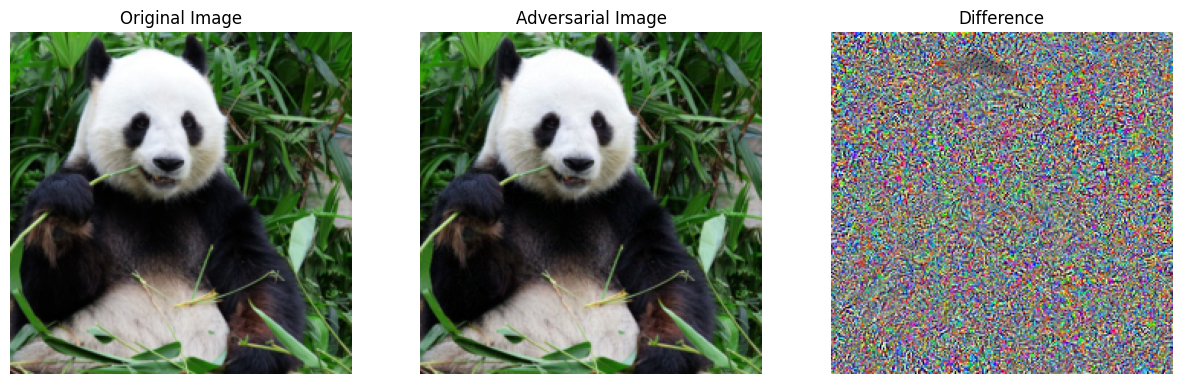

In [ ]:
# plot the original, perturbed images, and diff side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image.cpu().permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(adversarial_image.cpu().permute(1, 2, 0))
ax[1].set_title("Adversarial Image")
ax[1].axis("off")
ax[2].imshow(diff.cpu().permute(1, 2, 0))
ax[2].set_title("Difference")
ax[2].axis("off");

We can see that the two images look identical to the naked eye, but if we inspect the difference between them, we can notice some artifacts.